In [1]:
import polars as pl
import matplotlib.pyplot as plt
from numba import njit
import numpy as np
from tqdm import tqdm

In [2]:
def calc_weighted_price_no_numba(df):
    amount = df[:, 1]
    price = df[:, 0]
    return np.sum(amount * price) / np.sum(amount)

def past_return_no_numba(data_frame):
    weighted_prices = np.zeros(len(data_frame["tick"].unique()))
    for i in tqdm(range(len(data_frame["tick"].unique()))):
        table_tick = data_frame.filter(pl.col('tick') == data_frame["tick"].unique()[i]).drop("tick").to_numpy()
        weighted_prices[i] = calc_weighted_price_numba(table_tick)
    return weighted_prices

@njit(nogil=True, fastmath=True)
def calc_weighted_price_numba(df):
    amount = df[:, 1]
    price = df[:, 0]
    return np.sum(amount * price) / np.sum(amount)

@njit(nogil=True, fastmath=True)
def past_return_numba(data_frame):
    weighted_prices = np.zeros(len(data_frame["tick"].unique()))
    for i in range(len(data_frame["tick"].unique())):
        table_tick = data_frame.filter(pl.col('tick') == data_frame["tick"].unique()[i]).drop("tick").to_numpy()
        weighted_prices[i] = calc_weighted_price_numba(table_tick)
    return weighted_prices

In [3]:
trades_spot = pl.read_csv('trades.spot.csv').drop(["seq", "remote_ts", "remote_ts2", "side",])

ts_start = trades_spot["local_ts"][0]
trades_spot = trades_spot.with_columns(
    tick = ((pl.col("local_ts") - ts_start) // (50 * 10**6))
)
trades_spot = trades_spot.drop("local_ts")

In [4]:
def get_timings(data_frame, sizes):
    plain_iteration_times = []
    numba_times = []
    no_numba_times = []
    polars_times = []

    for size in sizes:    
        data_frame_capped = data_frame[:size]
        print("plain_iteration")
        plain_iteration_time = %timeit -n 1 -r 1 -o dummy = np.array([0 for name, data in data_frame_capped.group_by("tick", maintain_order=True)])
        print("numba")
        numba_time = %timeit -n 1 -r 1 -o weighted_prices_numba = np.array([calc_weighted_price_numba(data.drop("tick").to_numpy()) for name, data in data_frame_capped.group_by("tick", maintain_order=True)])
        print("no numba")
        no_numba_time = %timeit -n 1 -r 1 -o weighted_prices_no_numba = np.array([calc_weighted_price_no_numba(data.drop("tick").to_numpy()) for name, data in data_frame_capped.group_by("tick", maintain_order=True)])
        print("polars")
        polars_time = %timeit -n 1 -r 1 -o weighted_prices_polars = data_frame_capped.group_by("tick", maintain_order=True).agg((pl.col("price") * pl.col("amount")).sum() / pl.col("amount").sum())

        plain_iteration_times.append(plain_iteration_time.average)
        numba_times.append(numba_time.average)
        no_numba_times.append(no_numba_time.average)
        polars_times.append(polars_time.average)

    return plain_iteration_times, numba_times, no_numba_times, polars_time

In [5]:
sizes = 10 ** np.arange(1, 7, 1) * 7
plain_iteration_times, numba_times, no_numba_times, polars_time = get_timings(trades_spot, sizes)

plain_iteration
1.31 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
numba
682 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
no numba
1.78 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
polars
504 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
plain_iteration
4.53 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
numba
7.18 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
no numba
8.45 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
polars
211 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
plain_iteration
27.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
numba
66.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
no numba
81.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
polars
406 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
plain_iteration
255 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
numba
684 ms ± 0 ns per loop (

In [6]:
plain_iteration_times = np.array(plain_iteration_times)
numba_times = np.array(numba_times)
no_numba_times = np.array(no_numba_times)
polars_time = np.array(polars_time)

numba_times_less_iteration = numba_times - plain_iteration_times
no_numba_times_less_iteration = no_numba_times - plain_iteration_times

Text(0.5, 1.0, 'Numba vs trivial implementation log')

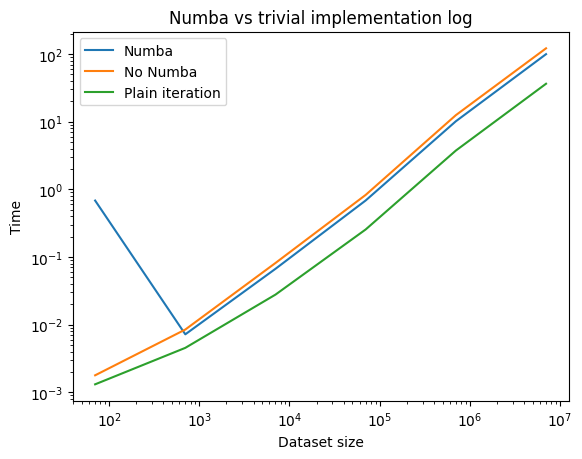

In [9]:
plt.plot(sizes, numba_times, label = 'Numba')
plt.plot(sizes, no_numba_times, label = 'No Numba')
plt.plot(sizes, plain_iteration_times, label = 'Plain iteration')
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Dataset size")
plt.ylabel("Time")
plt.legend()
plt.title("Numba vs trivial implementation log")

Text(0.5, 1.0, 'Numba vs trivial implementation')

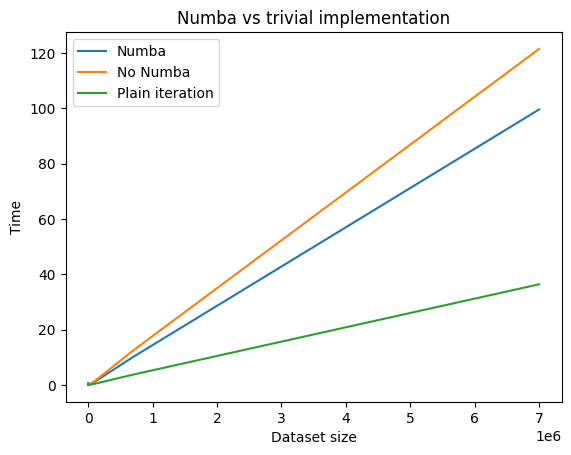

In [12]:
plt.plot(sizes, numba_times, label = 'Numba')
plt.plot(sizes, no_numba_times, label = 'No Numba')
plt.plot(sizes, plain_iteration_times, label = 'Plain iteration')
plt.xlabel("Dataset size")
plt.ylabel("Time")
plt.legend()
plt.title("Numba vs trivial implementation")

Text(0.5, 1.0, 'Numba vs trivial implementation less trivial iteration log')

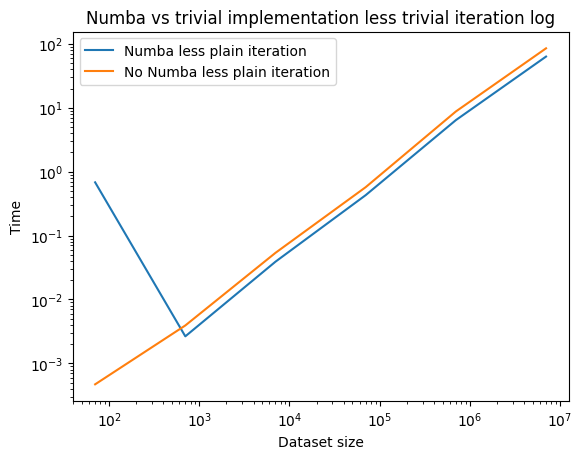

In [11]:
plt.plot(sizes, numba_times_less_iteration, label = 'Numba less plain iteration')
plt.plot(sizes, no_numba_times_less_iteration, label = 'No Numba less plain iteration')
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Dataset size")
plt.ylabel("Time")
plt.legend()
plt.title("Numba vs trivial implementation less trivial iteration log")

Text(0.5, 1.0, 'Numba vs trivial implementation less trivial iteration')

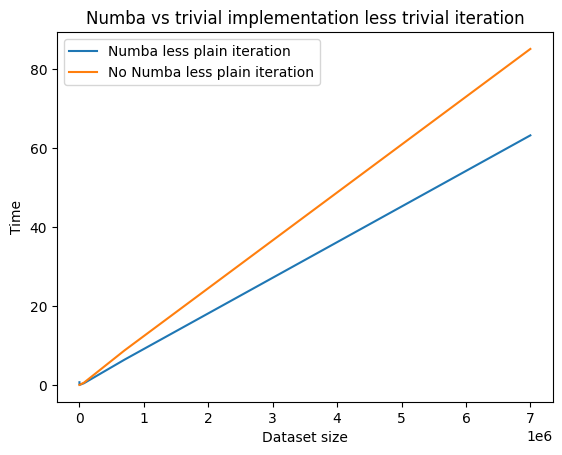

In [13]:
plt.plot(sizes, numba_times_less_iteration, label = 'Numba less plain iteration')
plt.plot(sizes, no_numba_times_less_iteration, label = 'No Numba less plain iteration')
plt.xlabel("Dataset size")
plt.ylabel("Time")
plt.legend()
plt.title("Numba vs trivial implementation less trivial iteration")